In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen, phate
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


Ligand **-***sender|receiver***->** Receptor **-->** Pathway **-->** Target 

* L-R interactions from NichetNet (or anything else really)
~* Target gene list from Nichenet too.~ 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

We will have to be carefull with the targets added, as in the previous nichenetKG they were the vast majority of nodes -> even subsetting targets to genes that are neither L, nor R, nor TF, we still get thousands of possible nodes.... -> NO TARGETS FOR NOW.

In v2 we will actually work with a small subset of the KG, focusing just on pathways of interest and aiming to have circa 50 nodes....


First pathway selection:

* (SignallingTransduction) WNT signaling
* (ST) TGFB signaling
* (ST) Receptor TK signaling: includes EGF and PI3K
* (ST) MAPK signaling
* (ST) Hippo signaling: includes YAP
* Cell-cell commns
* Programmed cell death
* Cell cycle
* Cellular responses to stimuli


# Data acquisition

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

## REACTOME

In [4]:
#LIst of pathways of interest (2nd level pathways)
dREACTpaths = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dREACTpaths = dREACTpaths.loc[dREACTpaths[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ]),1]
dREACTpaths.shape

(35,)

In [5]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_All_Levels.txt", sep="\t", header=None)
dREACTpe = dREACTpe.loc[dREACTpe[0].str.startswith("ENSG")|dREACTpe[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
dREACTpe = dREACTpe.loc[dREACTpe[3].isin(dREACTpaths)]
dREACTpe = dREACTpe.loc[dREACTpe[2].str.match("^\S*[A-Z0-9]+\S*[A-Z0-9]+(\sgene)?(\(\S+\))? \[")][[2,3,5]].dropna().drop_duplicates()
print(dREACTpe[3].nunique())
dREACTpe

35


,2,3,5
1533488,GCLC gene [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533489,GCLC [cytosol],R-HSA-2262752,Cellular responses to stress
1533535,NFYA [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533688,CFTR [plasma membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
1533689,CFTR [Golgi-associated vesicle membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
...,...,...,...
2068808,miR-24-2 [cytosol],R-HSA-2262752,Cellular responses to stress
2068823,miR-24-1 [cytosol],R-HSA-2262752,Cellular responses to stress
2070835,ARHGAP11B [cytosol],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
2075559,NPBWR1 [plasma membrane],R-HSA-372790,Signaling by GPCR


## Ligand-Receptors

NicheNet

In [6]:
# %%R -o dNNlr,dNNgr,dNNgrt,dNNlt
# #Directly load RDS object from NicheNet's zenodo repo
# dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
# dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))
# dNNgrt = readRDS(url("https://zenodo.org/record/3260758/files/tf_target_matrix.rds"))
# dNNlt = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))

In [7]:
%%R -o dNNlr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))

In [8]:
print("Ligand-Receptor\n",dNNlr.describe())
# print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304


,from,to,source,database
1,CXCL1,CXCR2,kegg_cytokines,kegg
2,CXCL2,CXCR2,kegg_cytokines,kegg
3,CXCL3,CXCR2,kegg_cytokines,kegg
4,CXCL5,CXCR2,kegg_cytokines,kegg
5,PPBP,CXCR2,kegg_cytokines,kegg
...,...,...,...,...
12647,CXCL6,PIGR,ppi_lr_go,ppi_prediction_go
12648,RLN1,GPR25,ppi_lr_go,ppi_prediction_go
12649,RLN1,RAMP3,ppi_lr_go,ppi_prediction_go
12650,PIK3CB,TNFRSF10A,ppi_bidir_r_go,ppi_prediction_go


## TEST: Gene targets

In [9]:
# #See how many of the targets from NicheNet arenot either ligands nor TFs nor receptors
#     #TF are cehcked against NN DBs, whereas ligands and receptors will be checked against the current
# dNNgr.loc[~dNNgr["to"].isin(dNNgr["from"])]["to"].unique().shape

In [10]:
# testlist = dNNgr.loc[~dNNgr["to"].isin(dNNgr["from"])]["to"]
# testlist = testlist.loc[~testlist.isin(dKGlrp[0]) & ~testlist.isin(dKGlrp[2])].unique()
# testlist.shape

## END of TEST

On the L-R side, NicheNet seems to have a higher number of interactions
modelled in. We can just use them *as is*.

The tf_target and ligand_target matrix objects don't look to be as useful since the targets they have are actually, if anything, somewaht longer than the targets in the gene regulation database (uncomment .md below to see)
Manual exploration of the tf_target database revealed that all genes with bio meaning I could think of are present in this list.
Afterall,we have 25k genes in here. This is thus, not useful at all.

<!-- Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304

TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691

TF-Target 2
 (25345, 4486) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
Ligand-Target
 (25345, 688) [[0.00035343 0.00040413 0.00037299 ... 0.00028765 0.00036615 0.00032276]
 [0.00016509 0.00015092 0.00015836 ... 0.00014044 0.0001839  0.00017542]
 [0.00057872 0.00045963 0.00038959 ... 0.00053559 0.00051685 0.00040327]
 ...
 [0.00043514 0.00052277 0.00040791 ... 0.00043696 0.00092245 0.00045744]
 [0.00041811 0.00049604 0.00045687 ... 0.00036184 0.00059071 0.00040423]
 [0.00050178 0.00055816 0.00048933 ... 0.00053238 0.00099519 0.00057892]] -->
 

CellChat

In [11]:
dCClr = pd.read_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz",header=None)
dCClr

,0,1,2,3
0,TGFB1,LRinteraction,TGFBR1,TGFb
1,TGFB1,LRinteraction,TGFBR2,TGFb
2,TGFB2,LRinteraction,TGFBR1,TGFb
3,TGFB2,LRinteraction,TGFBR2,TGFb
4,TGFB3,LRinteraction,TGFBR1,TGFb
...,...,...,...,...
1976,VCAM1,LRinteraction,ITGA4,VCAM
1977,VCAM1,LRinteraction,ITGB1,VCAM
1978,VCAM1,LRinteraction,ITGA9,VCAM
1979,VCAM1,LRinteraction,ITGB7,VCAM


Merge NicheNet and CellChat LR databases

In [12]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dCClr = pd.DataFrame({
            "head":dCClr[0],
            "relation":np.repeat("LR", dCClr.shape[0]),
            "tail":dCClr[2]
        })
dLR = pd.concat([dNNlr, dCClr]).drop_duplicates().reset_index(drop=True)
del dNNlr,dCClr
dLR

,head,relation,tail
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
12927,THY1,LR,ITGB2
12928,THY1,LR,ITGAX
12929,THY1,LR,ITGAV
12930,THY1,LR,ITGB3


## PTMs
Get the PTMs from the cytof dataset. Manually curate them and ensure they match to proper REACTOME PE IDS.

In [13]:
dCyt = pd.read_csv(f"{data_dir}/Omics/dWTfib_cytof.txt",sep="\t").filter(regex = "^\d+|^file_identifier")
dCyt

,89Y_pHH3_S28,111Cd_CD44_v2,113In_CEACAM1_CD66a_v2,114Cd_CK18_v2,115In_Pan-CK_v5,122Te_Barcode,123Te_Barcode,124Te_Barcode,125Te_Barcode,126Te_Barcode,...,172Yb_pS6_S235_236_v2,173Yb_PDPN_v2,174Yb_RFP,175Lu_Vimentin,176Yb_Cyclin_B1_2_v2,191Ir_DNA_1,193Ir_DNA_2,194Pt_Cisplatin,209Bi_CK18,file_identifier
0,0.000000,1990.980957,18.211060,2928.800781,1973.129028,771.304932,14.819576,563.619202,699.982117,25.099878,...,11688.049805,504.713531,29.877979,4299.611816,200.047882,63777.085938,121983.914062,18089.599609,1510.892578,Pro_WTfib_fib
1,0.000000,825.002075,1.621021,8.841931,45.782940,400.186676,53.228016,331.107513,406.801514,51.104706,...,5725.374512,2165.157471,213.488480,1535.135986,132.647461,18011.433594,32582.429688,1185.106079,0.000000,Pro_WTfib_fib
2,0.545875,23.752832,2.710696,75.029808,224.630737,6442.486816,119.965919,6082.173828,6060.972168,700.094177,...,0.000000,515.552185,825.009094,0.000000,37.127651,36602.984375,72815.867188,14817.324219,43.982540,Pro_WTfib_fib
3,1.687439,993.330872,4.313036,18.532772,19.012230,179.756882,25.230639,174.673813,156.020660,21.305735,...,31.062332,453.606934,234.555603,32.569691,10.049050,25414.136719,47861.183594,1220.816040,1.686805,Pro_WTfib_fib
4,0.000000,55.538124,1.648003,29.172148,8.418515,384.167419,13.115532,243.553711,243.389740,24.149267,...,21.605457,161.520538,49.635128,0.000000,0.000000,13607.113281,23980.585938,1471.665405,0.000000,Pro_WTfib_fib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.575287,0.000000,29.917067,1177.036377,1878.979126,18780.707031,347.416901,17428.015625,18221.324219,1969.474243,...,5.057156,105.512360,56.930191,0.000000,128.641403,16511.298828,31044.115234,7563.200195,516.480652,Pro_WTfib_epi
23945,8.733110,51.412457,316.347076,2758.709229,1413.775513,17464.484375,319.504669,16184.413086,17701.402344,1702.833252,...,2.509986,6.395815,48.340462,3.997385,336.654144,15596.995117,32046.751953,1247.258301,2554.626221,Pro_WTfib_epi
23946,0.000000,32.676712,47.151875,218.732193,142.701355,4548.200684,99.833855,4417.928711,4601.003906,413.944672,...,0.000000,0.000000,67.100281,0.000000,836.829224,12291.399414,25326.033203,1548.010376,302.388184,Pro_WTfib_epi
23947,2.054595,5.049978,3.555531,236.509842,129.904480,41.158947,3.220307,73.682106,52.007206,9.751757,...,0.000000,0.000000,15.115691,0.000000,27.275177,2755.387939,6044.491699,109.323814,568.037659,Pro_WTfib_epi


In [14]:
dCyt.columns

Index(['89Y_pHH3_S28', '111Cd_CD44_v2', '113In_CEACAM1_CD66a_v2',
       '114Cd_CK18_v2', '115In_Pan-CK_v5', '122Te_Barcode', '123Te_Barcode',
       '124Te_Barcode', '125Te_Barcode', '126Te_Barcode', '127I_IdU',
       '128Te_Barcode', '130Te_Barcode', '140Ce_EQ_Beads',
       '141Pr_pPDK1_S241_v4', '142Nd_cCaspase_3_D175_v3', '143Nd_NaK_ATPase',
       '144Nd_pMEK1_2_S221_v3', '145Nd_CD34', '146Nd_pMKK4_SEK1_S257_v3',
       '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
       '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
       '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
       '162Dy_LRIG1_1_v2', '163Dy_pP90RSK_T359_Hu_v5', '164Dy_Alpha-SMA_2',
       '165Ho_Beta-catenin_Active_1_v4', '166Er_pGSK-3b_S9_v2',
       '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD

In [15]:
dPTMs = [
    '89Y_pHH3_S28',
    '141Pr_pPDK1_S241_v4',
    '142Nd_cCaspase_3_D175_v3',
    '144Nd_pMEK1_2_S221_v3',
    '146Nd_pMKK4_SEK1_S257_v3',
    '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
    '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
    '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
    '163Dy_pP90RSK_T359_Hu_v5',
    '166Er_pGSK-3b_S9_v2',
    '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD2_3_v4', '169Tm_pSTAT3_Y705',
    '170Er_pMEK1_2_S221_v2',
    '172Yb_pS6_S235_236_v2'
    
]
dCyt = dCyt.filter(dPTMs)
dCyt.columns

Index(['89Y_pHH3_S28', '141Pr_pPDK1_S241_v4', '142Nd_cCaspase_3_D175_v3',
       '144Nd_pMEK1_2_S221_v3', '146Nd_pMKK4_SEK1_S257_v3',
       '147Sm_pBTK_Y511_v4', '148Nd_pSRC_Y418_v5', '149Sm_p4EBP1_T37_T46_v2',
       '150Nd_pRB_S807_S811_v3', '152Sm_pAKT_T308_v7', '153Eu_pCREB_S133_v8',
       '154Sm_pSMAD1_5_9_v5', '155Gd_pAKT_S473_v6', '156Gd_pNF-kB_p65_S529_v4',
       '157Gd_pMKK3_MKK6_S189_207_v3', '158Gd_pP38_MAPK_T180_Y182_v3',
       '159Tb_pMAPKAPK2_T334_v2', '160Gd_pAMPKa_T172_v3', '161Dy_pBAD_S112_v4',
       '163Dy_pP90RSK_T359_Hu_v5', '166Er_pGSK-3b_S9_v2',
       '167Er_pERK1_2_T202_Y204_v2', '168Er_pSMAD2_3_v4', '169Tm_pSTAT3_Y705',
       '170Er_pMEK1_2_S221_v2', '172Yb_pS6_S235_236_v2'],
      dtype='object')

In [16]:
dREACTpe[2]

1533488                     GCLC gene [nucleoplasm]
1533489                              GCLC [cytosol]
1533535                          NFYA [nucleoplasm]
1533688                      CFTR [plasma membrane]
1533689    CFTR [Golgi-associated vesicle membrane]
                             ...                   
2068808                          miR-24-2 [cytosol]
2068823                          miR-24-1 [cytosol]
2070835                         ARHGAP11B [cytosol]
2075559                    NPBWR1 [plasma membrane]
2075577     UGT1A3 [endoplasmic reticulum membrane]
Name: 2, Length: 9385, dtype: object

In [17]:
# dREACTpe.loc[dREACTpe[2].str.contains("H3F3A")] #phospho is too restrictive
# dREACTpe.loc[dREACTpe[2].str.contains("PDK1")]
# dREACTpe.loc[dREACTpe[2].str.contains("CASP3")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(1|2)\s+")]#MEK1 and 2 are MAP2K1 and 2. No S221
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S257\S*-MAP2K4")]
# dREACTpe.loc[dREACTpe[2].str.contains("BTK")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*Y41\S*-SRC")]#S418 NOT PRESENT
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T37,T46\S*-EIF4EBP1")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S8\S*-RB1")] #S811 AND S807 ARE SEPARATE TARGETS!
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T308\S*-AKT1")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S473\S*-AKT1")] 
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S133\S*-CREB1")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(1|5|9)")]
# dREACTpe.loc[dREACTpe[2].str.contains("RELA")] #Rela is the gene for NFKB p65
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*S\S*-MAP2K(3|6)")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T180,Y182\S*-MAPK(14|11|13|12)")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T334\S*-MAPKAPK2")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T1\S*PRKAA1")] #PRKAA1 is AMPKa subunit alpha
# dREACTpe.loc[dREACTpe[2].str.contains("BAD")] #S112 not present
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*T359\S*-RPS6KA1")]#Rps6ka1 is P90RSK
# dREACTpe.loc[dREACTpe[2].str.contains("GSK3B")] #Limit to S9 too stringent
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-MAPK(3|1)\s+")]#MAPK3 is ERK1. MAPK1 is ERK2, which doesnt have neither T202 nor Y204
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-SMAD(2|3)")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S*Y705\S*-STAT3")]
# dREACTpe.loc[dREACTpe[2].str.contains("p-\S+-RPS6\s+")]

In [18]:
#Dict of regex used to get the PTMs
PTMdict = {
    '89Y_pHH3_S28':"H3F3A",
    '141Pr_pPDK1_S241_v4':"PDK1",
    '142Nd_cCaspase_3_D175_v3':"CASP3",
    '144Nd_pMEK1_2_S221_v3':"p-\S*S\S*-MAP2K(1|2)\s+",
    '146Nd_pMKK4_SEK1_S257_v3':"p-\S*S257\S*-MAP2K4",
    '147Sm_pBTK_Y511_v4':"BTK",
    '148Nd_pSRC_Y418_v5':"p-\S*Y41\S*-SRC",
    '149Sm_p4EBP1_T37_T46_v2':"p-\S*T37,T46\S*-EIF4EBP1",
    '150Nd_pRB_S807_S811_v3':"p-\S*S8\S*-RB1",
    '152Sm_pAKT_T308_v7':"p-\S*T308\S*-AKT1",
    '153Eu_pCREB_S133_v8':"p-\S*S473\S*-AKT1",
    '154Sm_pSMAD1_5_9_v5':"p-\S*S133\S*-CREB1",
    '155Gd_pAKT_S473_v6':"p-\S+-SMAD(1|5|9)",
    '156Gd_pNF-kB_p65_S529_v4':"RELA",
    '157Gd_pMKK3_MKK6_S189_207_v3':"p-\S*S\S*-MAP2K(3|6)", 
    '158Gd_pP38_MAPK_T180_Y182_v3':"p-\S*T180,Y182\S*-MAPK(14|11|13|12)",
    '159Tb_pMAPKAPK2_T334_v2':"p-\S*T334\S*-MAPKAPK2", 
    '160Gd_pAMPKa_T172_v3':"p-\S*T1\S*PRKAA1", 
    '161Dy_pBAD_S112_v4':"BAD",
    '163Dy_pP90RSK_T359_Hu_v5':"p-\S*T359\S*-RPS6KA1",
    '166Er_pGSK-3b_S9_v2':"GSK3B",
    '167Er_pERK1_2_T202_Y204_v2':"p-\S+-MAPK(3|1)\s+", 
    '168Er_pSMAD2_3_v4':"p-\S+-SMAD(2|3)", 
    '169Tm_pSTAT3_Y705':"p-\S*Y705\S*-STAT3",
    '170Er_pMEK1_2_S221_v2':"p-\S*S\S*-MAP2K(1|2)\s+",
    '172Yb_pS6_S235_236_v2':"p-\S+-RPS6\s+"
}

# KG assembly

* Set of triples from L-R database:
    * Replicate triples for as many pathways are found to contain both Ligand and Receptor entities
* Set of triples from R-PTMs:
    * If Receptor and PTM in the same pathway, define triple with pathway edge annotation.
    * Get pathway PTMs by using the contains method snippet above and subsetting to unique entries in 5.
    * Notes:
        * For ab with multiple targets, have one entity per target
        * In the KG, define PTM entity names as GENE names
        * Before projecting:
            * Change column names in cytof dataset to gene names
            * Duplicate columns that have multiple targets

## L-R pathway edges

In [19]:
pathways2rmv = [
    "Death Receptor Signalling",
    "Integrin signaling",
    "Intracellular signaling by second messengers",
    "MTOR signalling",
    "Signaling by Erythropoietin",
    "Signaling by GPCR",
    "Signaling by Hedgehog",
    "Signaling by Leptin",
    "Signaling by NOTCH",
    "Signaling by Nuclear Receptors",
    "Signaling by Non-Receptor Tyrosine Kinases",
    "Signaling by Rho GTPases, Miro GTPases and RHOBTB3",
    "Fanconi Anemia Pathway",
    "Base Excision Repair",
    "Cellular responses to stress",
    "Chromosome Maintenance",
    "Nephrin family interactions",
    "Response to metal ions"
]

pathways2keep = [
    "Signaling by WNT",
    "Signaling by TGFB family members"
#     "Signaling by Receptor Tyrosine Kinases",
#     "MAPK family signaling cascades",
#     "Signaling by Hippo"
]

In [20]:
#Make df with only gene names. Group by pathway. IF both L and R in same group, we have a hit!
mdPathPE = dREACTpe.copy(deep=True)
mdPathPE[2] = mdPathPE[2].str.extract("^([A-Z0-9]+-*[A-Z0-9]+)")[0]
mdPathPE = mdPathPE.dropna().drop_duplicates()
# mdPathPE = mdPathPE.loc[~mdPathPE[5].isin(pathways2rmv)] #Removing pathways from the delete list
mdPathPE = mdPathPE.loc[mdPathPE[5].isin(pathways2keep)] #Selecting pathways from the keep list
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2                        3         \
                                 count unique    top freq count unique   
5                                                                        
Signaling by TGFB family members   119    119  WWTR1    1   119      1   
Signaling by WNT                   298    298    N4G    1   298      1   

                                                      
                                            top freq  
5                                                     
Signaling by TGFB family members  R-HSA-9006936  119  
Signaling by WNT                   R-HSA-195721  298

In [21]:
for name, group in mdPathPE:
    print(name)
    print(group)

Signaling by TGFB family members
               2              3                                 5
1543914    WWTR1  R-HSA-9006936  Signaling by TGFB family members
1545089    STRAP  R-HSA-9006936  Signaling by TGFB family members
1548467  ZFYVE16  R-HSA-9006936  Signaling by TGFB family members
1551090    LTBP1  R-HSA-9006936  Signaling by TGFB family members
1551299   NEDD4L  R-HSA-9006936  Signaling by TGFB family members
...          ...            ...                               ...
1974938     E2F4  R-HSA-9006936  Signaling by TGFB family members
1989802   PPP1CB  R-HSA-9006936  Signaling by TGFB family members
1993499    UBA52  R-HSA-9006936  Signaling by TGFB family members
2031825    ITGB3  R-HSA-9006936  Signaling by TGFB family members
2033288     GDF2  R-HSA-9006936  Signaling by TGFB family members

[119 rows x 3 columns]
Signaling by WNT
                 2             3                 5
1534004        N4G  R-HSA-195721  Signaling by WNT
1534005      WNT16  R-HSA-195721

In [22]:
%%time
dLRpath = pd.DataFrame(columns=["head","relation","tail"])
for i in dLR.iterrows():
    for name, group in mdPathPE:
        if any(group[2].str.contains(i[1]["head"])):
            if any(group[2].str.contains(i[1]["tail"])):
                row = pd.Series({"head":i[1]["head"], "relation":name, "tail":i[1]["tail"]})
                dLRpath = pd.concat([dLRpath, row.to_frame().T])
dLRpath = dLRpath.reset_index(drop=True)
dLRpath.to_csv(f"{data_dir}/dLRpath.csv.tar.gz", index=False)

CPU times: user 14.4 s, sys: 7.48 ms, total: 14.5 s
Wall time: 14.5 s


In [23]:
dLRpath = pd.read_csv(f"{data_dir}/dLRpath.csv.tar.gz")

In [24]:
dLRpath

,head,relation,tail
0,TGFB1,Signaling by TGFB family members,TGFBR1
1,TGFB1,Signaling by TGFB family members,TGFBR2
2,TGFB2,Signaling by TGFB family members,TGFBR1
3,TGFB2,Signaling by TGFB family members,TGFBR2
4,TGFB3,Signaling by TGFB family members,TGFBR1
...,...,...,...
305,LTA,Signaling by WNT,LTB
306,F2,Signaling by TGFB family members,PARD3
307,COL1A2,Signaling by TGFB family members,ITGB1
308,COL1A2,Signaling by TGFB family members,ITGAV


## R-PTM pathway edges

In [25]:
mdPathPE = dREACTpe.copy(deep=True)
#No longer filter to just genes
mdPathPE = mdPathPE.dropna().drop_duplicates()
# mdPathPE = mdPathPE.loc[~mdPathPE[5].isin(pathways2rmv)] #Removing pathways from the delete list
mdPathPE = mdPathPE.loc[mdPathPE[5].isin(pathways2keep)] #Selecting pathways from the keep list
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2         \
                                 count unique   
5                                               
Signaling by TGFB family members   199    199   
Signaling by WNT                   463    463   

                                                                                  \
                                                                             top   
5                                                                                  
Signaling by TGFB family members                                 WWTR1 [cytosol]   
Signaling by WNT                  N4GlycoAsn-WNT16 [endoplasmic reticulum lumen]   

                                          3                             
                                 freq count unique            top freq  
5                                                                       
Signaling by TGFB family members    1   199      1  R-HSA-9006936  199  
Signaling by WNT                    1   463      1   R-HSA-195721  463

In [26]:
PTMdict.values()

dict_values(['H3F3A', 'PDK1', 'CASP3', 'p-\\S*S\\S*-MAP2K(1|2)\\s+', 'p-\\S*S257\\S*-MAP2K4', 'BTK', 'p-\\S*Y41\\S*-SRC', 'p-\\S*T37,T46\\S*-EIF4EBP1', 'p-\\S*S8\\S*-RB1', 'p-\\S*T308\\S*-AKT1', 'p-\\S*S473\\S*-AKT1', 'p-\\S*S133\\S*-CREB1', 'p-\\S+-SMAD(1|5|9)', 'RELA', 'p-\\S*S\\S*-MAP2K(3|6)', 'p-\\S*T180,Y182\\S*-MAPK(14|11|13|12)', 'p-\\S*T334\\S*-MAPKAPK2', 'p-\\S*T1\\S*PRKAA1', 'BAD', 'p-\\S*T359\\S*-RPS6KA1', 'GSK3B', 'p-\\S+-MAPK(3|1)\\s+', 'p-\\S+-SMAD(2|3)', 'p-\\S*Y705\\S*-STAT3', 'p-\\S*S\\S*-MAP2K(1|2)\\s+', 'p-\\S+-RPS6\\s+'])

In [27]:
dLR["tail"].unique()

array(['CXCR2', 'CXCR1', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'XCR1',
       'CX3CR1', 'CCR6', 'CCR9', 'CCR4', 'CCR7', 'CCR2', 'CCR5', 'CCR3',
       'CCR1', 'CCR10', 'IL6ST', 'IL6R', 'IL11RA', 'LIFR', 'OSMR',
       'CNTFR', 'CSF3R', 'LEPR', 'IL13RA1', 'IL4R', 'IL12RB2', 'IL12RB1',
       'IL23R', 'CSF2RB', 'CSF2RA', 'IL3RA', 'IL5RA', 'IL2RG', 'IL2RB',
       'IL2RA', 'IL7R', 'IL9R', 'IL15RA', 'IL21R', 'CRLF2', 'EPOR', 'GHR',
       'PRLR', 'MPL', 'PDGFRA', 'PDGFRB', 'FLT1', 'KDR', 'FLT4', 'MET',
       'EGFR', 'CSF1R', 'KIT', 'FLT3', 'IFNAR2', 'IFNAR1', 'IFNGR2',
       'IFNGR1', 'IL10RB', 'IL10RA', 'IL20RA', 'IL22RA1', 'IL22RA2',
       'IFNLR1', 'TNFRSF10A', 'TNFRSF10B', 'TNFRSF10C', 'TNFRSF10D',
       'TNFRSF11B', 'TNFRSF11A', 'TNFRSF12A', 'TNFRSF1B', 'TNFRSF1A',
       'LTBR', 'TNFRSF14', 'TNFRSF6B', 'FAS', 'CD40', 'CD27', 'TNFRSF8',
       'TNFRSF9', 'TNFRSF4', 'TNFRSF18', 'TNFRSF17', 'TNFRSF13B',
       'TNFRSF13C', 'EDAR', 'EDA2R', 'TGFBR1', 'TGFBR2', 'ACVR1',
       'ACVR2A',

In [28]:
%%time
dRPTMpath = pd.DataFrame(columns=["head","relation","tail"])
for p in PTMdict.values():
    for r in dLR["tail"].unique():
        for name, group in mdPathPE:
            if any(group[2].str.contains(r)):
                if any(group[2].str.contains(p)):
                    row = pd.Series({"head":r, "relation":name, "tail":p})
                    dRPTMpath = pd.concat([dRPTMpath, row.to_frame().T])
dRPTMpath = dRPTMpath.dropna().drop_duplicates().reset_index(drop=True)
dRPTMpath.to_csv(f"{data_dir}/dLPTMpath.csv.tar.gz", index=False)

<timed exec>:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


CPU times: user 28.8 s, sys: 10.2 ms, total: 28.8 s
Wall time: 28.8 s


In [29]:
dRPTMpath = pd.read_csv(f"{data_dir}/dLPTMpath.csv.tar.gz")

In [30]:
dRPTMpath

,head,relation,tail
0,LGR4,Signaling by WNT,H3F3A
1,LGR6,Signaling by WNT,H3F3A
2,LGR5,Signaling by WNT,H3F3A
3,FZD4,Signaling by WNT,H3F3A
4,FZD6,Signaling by WNT,H3F3A
...,...,...,...
170,ACVR1C,Signaling by TGFB family members,p-\S+-SMAD(2|3)
171,RHO,Signaling by TGFB family members,p-\S+-SMAD(2|3)
172,AR,Signaling by TGFB family members,p-\S+-SMAD(2|3)
173,LTB,Signaling by TGFB family members,p-\S+-SMAD(2|3)


## TEST Receptor2Target and PTM2Target

In [31]:
# mdPathPE = dREACTpe.copy(deep=True)
# #No longer filter to just genes
# mdPathPE = mdPathPE.dropna().drop_duplicates()
# mdPathPE = mdPathPE.groupby(by=[5])
# mdPathPE.describe()

In [32]:
# dLRpath["tail"].unique().shape

In [33]:
# dRPTMpath["tail"].unique().shape

In [34]:
# testlist

In [35]:
# %%time
# dRTpath = pd.DataFrame(columns=["head","relation","tail"])
# for t in testlist:
#     for r in dLRpath["tail"].unique():
#         for name, group in mdPathPE:
#             if any(group[2].str.contains(r)):
#                 if any(group[2].str.contains(t)):
#                     row = pd.Series({"head":r, "relation":name, "tail":t})
#                     dRTpath = pd.concat([dRTpath, row.to_frame().T])
# dRTpath = dRTpath.dropna().drop_duplicates().reset_index(drop=True)
# dRTpath.to_csv(f"{data_dir}/dRTpath.csv.tar.gz", index=False)

In [36]:
# dRTpath.describe()

In [37]:
# %%time
# dPTMTpath = pd.DataFrame(columns=["head","relation","tail"])
# for t in testlist:
#     for p in dRPTMpath["tail"].unique():
#         for name, group in mdPathPE:
#             if any(group[2].str.contains(p)):
#                 if any(group[2].str.contains(t)):
#                     row = pd.Series({"head":p, "relation":name, "tail":t})
#                     dPTMTpath = pd.concat([dPTMTpath, row.to_frame().T])
# dPTMTpath = dPTMTpath.dropna().drop_duplicates().reset_index(drop=True)
# dPTMTpath.to_csv(f"{data_dir}/dPTMTpath.csv.tar.gz", index=False)

In [38]:
# dPTMTpath.describe()

## Assembled KG

In [39]:
dKGlrp = pd.concat([dLRpath, dRPTMpath]).drop_duplicates().reset_index(drop=True)
dKGlrp

,head,relation,tail
0,TGFB1,Signaling by TGFB family members,TGFBR1
1,TGFB1,Signaling by TGFB family members,TGFBR2
2,TGFB2,Signaling by TGFB family members,TGFBR1
3,TGFB2,Signaling by TGFB family members,TGFBR2
4,TGFB3,Signaling by TGFB family members,TGFBR1
...,...,...,...
480,ACVR1C,Signaling by TGFB family members,p-\S+-SMAD(2|3)
481,RHO,Signaling by TGFB family members,p-\S+-SMAD(2|3)
482,AR,Signaling by TGFB family members,p-\S+-SMAD(2|3)
483,LTB,Signaling by TGFB family members,p-\S+-SMAD(2|3)


In [40]:
dKGlrp.to_csv(f"{data_dir}/dKGlrp_v2.csv.tar.gz", index=False, header=False)

In [41]:
dKGlrp = pd.read_csv(f"{data_dir}/dKGlrp_v2.csv.tar.gz", header=None)
dKGlrp

,0,1,2
0,TGFB1,Signaling by TGFB family members,TGFBR1
1,TGFB1,Signaling by TGFB family members,TGFBR2
2,TGFB2,Signaling by TGFB family members,TGFBR1
3,TGFB2,Signaling by TGFB family members,TGFBR2
4,TGFB3,Signaling by TGFB family members,TGFBR1
...,...,...,...
480,ACVR1C,Signaling by TGFB family members,p-\S+-SMAD(2|3)
481,RHO,Signaling by TGFB family members,p-\S+-SMAD(2|3)
482,AR,Signaling by TGFB family members,p-\S+-SMAD(2|3)
483,LTB,Signaling by TGFB family members,p-\S+-SMAD(2|3)


In [42]:
dKGlrp.groupby(by=1).describe()

0                        2         \
                                 count unique    top freq count unique   
1                                                                        
Signaling by TGFB family members   157     38  TGFB1   17   157     26   
Signaling by WNT                   328     53  WNT5A   14   328     23   

                                                        
                                              top freq  
1                                                       
Signaling by TGFB family members  p-\S+-SMAD(2|3)   25  
Signaling by WNT                            GSK3B   25

### As a multidigraph in NetworkX
Directed multigraph

In [43]:
G = networkx.from_pandas_edgelist(
    dKGlrp,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiDiGraph())
G

In [44]:
print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
# print("The graph is connected:",
#         networkx.is_connected(G))

# if not networkx.is_connected(G):
#     print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
#     Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
#     for i,g in enumerate(Gcomponents,start=1):
#         print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

MultiDiGraph with 95 nodes and 485 edges, with a density of 0.05431131019036954
We have this many isolates:  0


/tmp/ipykernel_20864/569377206.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


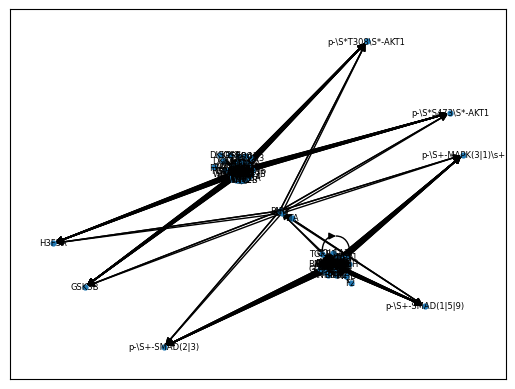

In [45]:
networkx.draw_networkx(G, node_size=12, font_size=6)

In [46]:
# #Degree analysis: For directed graph it's the full graph -> no connected
# degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
# dmax = max(degree_sequence)

# fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# # Create a gridspec for adding subplots of different sizes
# axgrid = fig.add_gridspec(5, 4)

# ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
# pos = networkx.spring_layout(Gcc, seed=10396953)
# networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
# networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# ax0.set_title("Connected components of G")
# ax0.set_axis_off()

# ax1 = fig.add_subplot(axgrid[3:, :2])
# ax1.plot(degree_sequence, "b-", marker="o")
# ax1.set_title("Degree Rank Plot")
# ax1.set_ylabel("Degree")
# ax1.set_xlabel("Rank")

# ax2 = fig.add_subplot(axgrid[3:, 2:])
# ax2.bar(*np.unique(degree_sequence, return_counts=True))
# ax2.set_title("Degree histogram")
# ax2.set_xlabel("Degree")
# ax2.set_ylabel("# of Nodes")

# fig.tight_layout()
# plt.show()

### As a multigraph in networtkX

In [47]:
G = networkx.from_pandas_edgelist(
    dKGlrp,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiGraph())
G

In [48]:
print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

MultiGraph with 95 nodes and 485 edges, with a density of 0.10862262038073908
We have this many isolates:  0
The graph is connected: True


/tmp/ipykernel_20864/2264486704.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


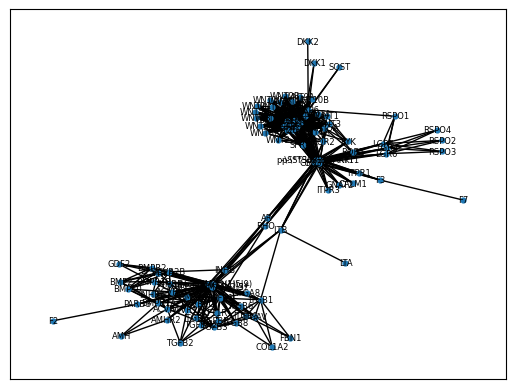

In [49]:
networkx.draw_networkx(G, node_size=12, font_size=6)

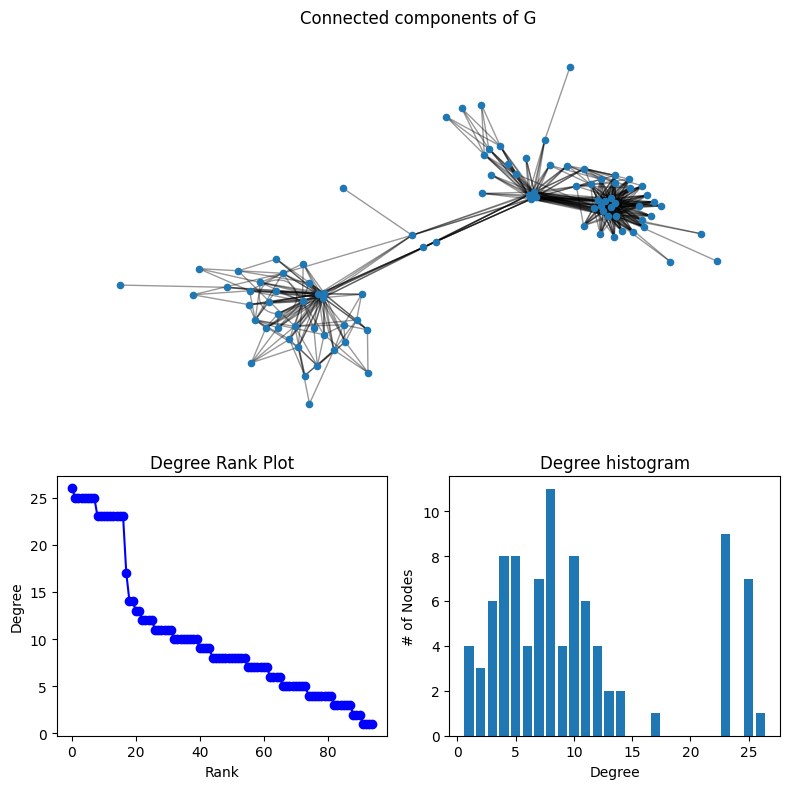

In [50]:
#Degree analysis: For directed graph it's the full graph -> no connected
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Embedding the KG

In [51]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [52]:
tf = TriplesFactory.from_labeled_triples(
        dKGlrp.to_numpy(dtype="str"),create_inverse_triples=False)
tf

TriplesFactory(num_entities=95, num_relations=2, create_inverse_triples=False, num_triples=485)

In [53]:
import json
with open(f"{data_dir}/dKGlrp2_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

In [54]:
import json
with open(f"{data_dir}/dKGlrp2_relationIDS.json","w") as outf:
    json.dump(tf.relation_id_to_label, outf)

In [55]:
modelKGE = "KGlrp2_50_unstratified_stopped_RGCN"

using automatically assigned random_state=166450242
Layers RGCNLayer(
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 2500)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 2500)
      )
    )
  )
  (self_loop): Linear(in_features=50, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) has parameters, but no reset_parameters.
Layers RGCNLayer(
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 2500)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 2500)
      )
    )
  )
  (self_loop): Linear(in_features=50, out_features=50, bias=True)
  (dropout): D

Training epochs on cuda:0:   0%|          | 0/72 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=49.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.5204081632653061. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-ed344261-e20e-40fc-a8f1-466cefb82881.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5714285714285714. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-ed344261-e20e-40fc-a8f1-466cefb82881.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.7959183673469388. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-ed344261-e20e-40fc-a8f1-466cefb82881.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.8163265306122449. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-ed344261-e20e-40fc-a8f1-466cefb82881.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 60: 0.8673469387755102. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-ed344261-e20e-40fc-a8f1-466cefb82881.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 60.


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/48.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=95, num_relations=2, create_inverse_triples=False, num_triples=388) to file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGlrp2_50_unstratified_stopped_RGCN/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGlrp2_50_unstratified_stopped_RGCN


RGCN(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): DistMultInteraction()
  (entity_representations): ModuleList(
    (0): RGCNRepresentation(
      (entity_embeddings): Embedding(
        (_embeddings): Embedding(95, 50)
      )
      (edge_weighting): SymmetricEdgeWeighting()
      (layers): ModuleList(
        (0): RGCNLayer(
          (fwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (bwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (self_loop): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): RGCNLayer(
          (fwd): Bases

<AxesSubplot: title={'center': 'Early Stopper Evaluation Plot'}, xlabel='Epoch', ylabel='hits_at_k'>

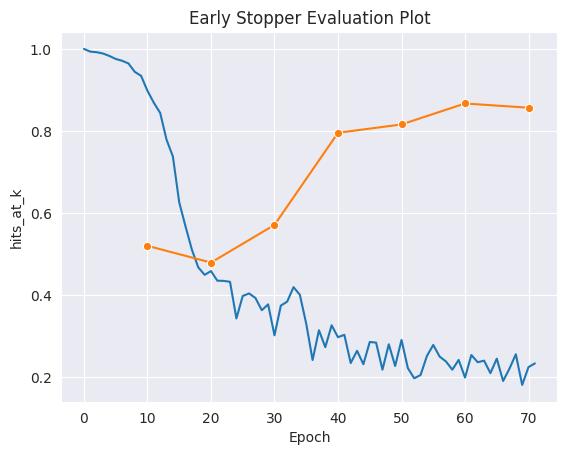

In [56]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="RGCN",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=72,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
result.plot_early_stopping()

In [57]:
try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

RGCN(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): DistMultInteraction()
  (entity_representations): ModuleList(
    (0): RGCNRepresentation(
      (entity_embeddings): Embedding(
        (_embeddings): Embedding(95, 50)
      )
      (edge_weighting): SymmetricEdgeWeighting()
      (layers): ModuleList(
        (0): RGCNLayer(
          (fwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (bwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (self_loop): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): RGCNLayer(
          (fwd): Bases

## Metadata

In [58]:
import json
with open(f"{data_dir}/dKGlrp2_entityIDS.json") as infile:
    entityIDS = json.load(infile)

In [59]:
import json
with open(f"{data_dir}/dKGlrp2_relationIDS.json") as infile:
    relationIDS = json.load(infile)

In [60]:
PathDict = pd.read_csv(f"{data_dir}/DBs/ReactomePathways.txt", sep="\t", header=None)
PathDict = PathDict.loc[PathDict[2]=="Homo sapiens",[0,1]].drop_duplicates()
PathDict = PathDict.set_index([0]).to_dict()[1]
# PathDict

In [61]:
#Metadata
mdPath2Path = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
mdPath2Path = mdPath2Path.loc[mdPath2Path[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ])].drop_duplicates()
mdPath2Path = mdPath2Path.replace(PathDict)
mdPath2Path = mdPath2Path.loc[mdPath2Path[1].isin(relationIDS.values())]
mdPath2Path = mdPath2Path.set_index([1]).reindex(index=relationIDS.values()).fillna(value="LR").reset_index()
mdPath2Path.head()

,1,0
0,Signaling by TGFB family members,Signal Transduction
1,Signaling by WNT,Signal Transduction


In [62]:
mdEntities = pd.DataFrame(columns=["entity","pathway"])
for i in entityIDS.values():
    if any(mdPathPE.obj[2].str.contains(i)):
        for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():
            row = pd.Series({"entity":i, "pathway":n})
            mdEntities = pd.concat([mdEntities, row.to_frame().T])
    else:
        row = pd.Series({"entity":i})
        mdEntities = pd.concat([mdEntities, row.to_frame().T])
            
mdEntities = mdEntities.loc[mdEntities["pathway"].isin(relationIDS.values()) | mdEntities["pathway"].isna()] #Get only pathways wecare about from pur entity list
mdEntities["1stPathways"] = mdEntities["pathway"].map(mdPath2Path.set_index([1]).to_dict()[0])    
mdEntities


/tmp/ipykernel_20864/4207475665.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if any(mdPathPE.obj[2].str.contains(i)):
/tmp/ipykernel_20864/4207475665.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():


,entity,pathway,1stPathways
0,ACVR1,Signaling by TGFB family members,Signal Transduction
0,ACVR1B,Signaling by TGFB family members,Signal Transduction
0,ACVR1C,Signaling by TGFB family members,Signal Transduction
0,ACVR2A,Signaling by TGFB family members,Signal Transduction
0,ACVR2B,Signaling by TGFB family members,Signal Transduction
...,...,...,...
0,p-\S*S473\S*-AKT1,Signaling by WNT,Signal Transduction
0,p-\S*T308\S*-AKT1,Signaling by WNT,Signal Transduction
0,p-\S+-MAPK(3|1)\s+,Signaling by TGFB family members,Signal Transduction
0,p-\S+-SMAD(1|5|9),Signaling by TGFB family members,Signal Transduction


In [63]:
#Add entity type metadata
mdEntities["Ligands"] = mdEntities["entity"].isin(dLR["head"])
mdEntities["Receptors"] = mdEntities["entity"].isin(dLR["tail"])
mdEntities["PTMs"] = mdEntities["entity"].isin(dRPTMpath["tail"])
# #DOES NOT WORK WITH PANDAS BELOW 1.5 (and collab env has 1.3.5....)
# mdEntities["EntityType"] = pd.from_dummies(mdEntities[["Ligands","Receptors","PTMs"]])
mdEntities

,entity,pathway,1stPathways,Ligands,Receptors,PTMs
0,ACVR1,Signaling by TGFB family members,Signal Transduction,False,True,False
0,ACVR1B,Signaling by TGFB family members,Signal Transduction,False,True,False
0,ACVR1C,Signaling by TGFB family members,Signal Transduction,False,True,False
0,ACVR2A,Signaling by TGFB family members,Signal Transduction,False,True,False
0,ACVR2B,Signaling by TGFB family members,Signal Transduction,False,True,False
...,...,...,...,...,...,...
0,p-\S*S473\S*-AKT1,Signaling by WNT,Signal Transduction,False,False,True
0,p-\S*T308\S*-AKT1,Signaling by WNT,Signal Transduction,False,False,True
0,p-\S+-MAPK(3|1)\s+,Signaling by TGFB family members,Signal Transduction,False,False,True
0,p-\S+-SMAD(1|5|9),Signaling by TGFB family members,Signal Transduction,False,False,True


## Nodes

In [64]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
dKGEnodes_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnodes_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ACVR1,0.661193,-0.667579,0.151677,0.525785,0.254360,-0.628382,0.667595,0.433907,-0.638313,0.032112,...,0.255684,-0.887183,0.498549,-0.422302,0.688557,-0.279119,0.440986,0.411817,-0.428140,-0.267098
ACVR1B,0.581314,-0.512175,0.153713,0.557406,0.167536,-0.575056,0.582852,0.333460,-0.554057,-0.234389,...,0.325372,-0.811509,0.447056,-0.277806,0.593301,-0.300828,0.429395,0.309851,-0.377173,-0.256332
ACVR1C,0.560601,-0.500342,0.014936,0.481937,0.086058,-0.350113,0.596627,0.312245,-0.514775,0.054447,...,0.186235,-0.510140,0.242183,-0.233123,0.537843,-0.311603,0.332775,0.198119,-0.266719,-0.240193
ACVR2A,0.692938,-0.619116,0.160284,0.438733,0.307177,-0.499086,0.615899,0.349416,-0.565733,0.174502,...,0.301017,-0.773386,0.378213,-0.372950,0.637653,-0.387999,0.495762,0.306046,-0.361903,-0.208154
ACVR2B,0.583322,-0.575121,0.152332,0.494262,0.154768,-0.419175,0.611752,0.292560,-0.506832,0.099409,...,0.253552,-0.668959,0.381742,-0.388745,0.500867,-0.414063,0.458546,0.297512,-0.303669,-0.211960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p-\S*S473\S*-AKT1,0.112507,0.495764,-0.838548,-0.162478,-0.558683,0.732159,-0.091883,-0.753614,0.265748,1.829969,...,0.722683,0.036685,-0.724752,0.024715,0.016745,-0.815245,-0.120884,-0.483761,0.520171,-0.769884
p-\S*T308\S*-AKT1,0.205895,0.515429,-0.756942,-0.180259,-0.558515,0.851403,-0.069688,-0.808189,0.127706,1.752207,...,0.752516,-0.217559,-0.510722,-0.015105,-0.035204,-0.817442,-0.079596,-0.544389,0.520321,-0.889245
p-\S+-MAPK(3|1)\s+,0.874641,-0.571101,0.140335,1.682521,-0.991395,-0.870981,1.230430,0.907135,-0.690567,-0.069457,...,-0.403049,1.358842,-1.187621,0.925419,0.786932,-0.583261,-0.633351,0.053290,-0.562098,0.873219
p-\S+-SMAD(1|5|9),0.742144,-0.614508,0.140307,1.348926,-0.905811,-0.773813,1.214121,0.880647,-0.722301,0.237303,...,-0.448192,1.264056,-1.191389,0.856771,0.640615,-0.502169,-0.680609,-0.042236,-0.467633,0.767940


In [65]:
l_and_r = pd.Series(entityIDS.values()).isin((mdEntities.loc[mdEntities["Ligands"]==True,"entity"])) & pd.Series(entityIDS.values()).isin((mdEntities.loc[mdEntities["Receptors"]==True,"entity"]))
l_and_r.describe()
# l_and_r_mask = np.array([0]*len(nodes))
# l_and_r_mask[l_and_r] = 1

count        95
unique        2
top       False
freq         91
dtype: object

In [66]:
deg = dict(networkx.degree(G))
deg = pd.DataFrame((deg.keys(), deg.values())).T
deg.set_index(0, inplace=True)
deg = deg.loc[np.array(G.nodes())].reindex(entityIDS.values())
deg[1] = deg[1].astype(float)
logdeg = deg.copy(deep=True)
logdeg[1] = np.log10(logdeg[1]) #NP.log needs floats and can't take in int.
print(deg.describe())
print(logdeg.describe())
deg

               1
count  95.000000
mean   10.210526
std     7.250671
min     1.000000
25%     5.000000
50%     8.000000
75%    12.000000
max    26.000000
               1
count  95.000000
mean    0.891843
std     0.343303
min     0.000000
25%     0.698970
50%     0.903090
75%     1.079181
max     1.414973


,1
0,
ACVR1,11.0
ACVR1B,8.0
ACVR1C,9.0
ACVR2A,8.0
ACVR2B,9.0
...,...
p-\S*S473\S*-AKT1,25.0
p-\S*T308\S*-AKT1,25.0
p-\S+-MAPK(3|1)\s+,25.0


### DR on KGE

In [67]:
from sklearn.decomposition import PCA

dKGEn_pca = PCA(n_components=2).fit_transform(dKGEnodes_50)
dKGEn_pca = pd.DataFrame(dKGEn_pca, index=entityIDS.values())

<AxesSubplot: title={'center': 'KGE nodes (col=Degree)'}, xlabel='PC-1', ylabel='PC-2'>

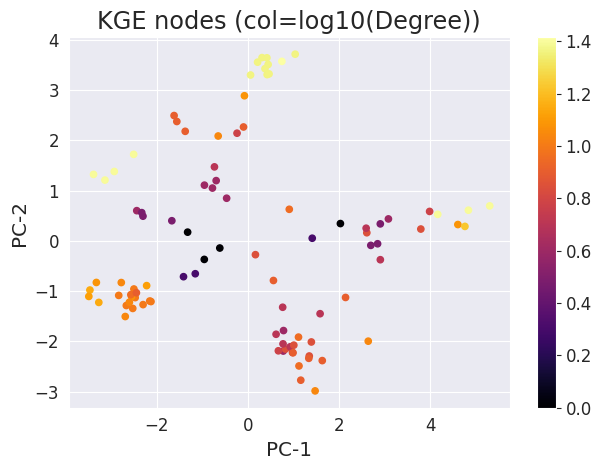

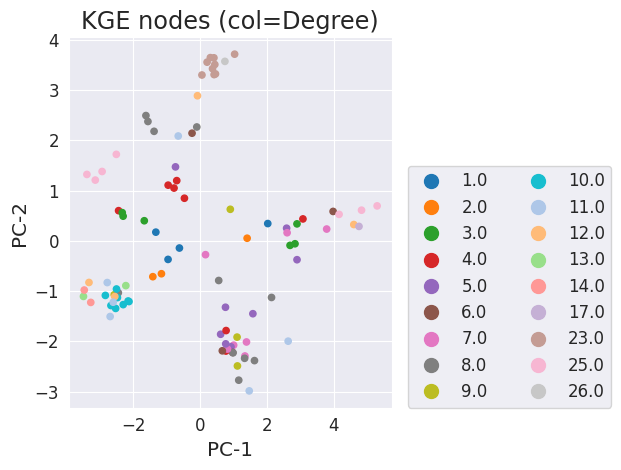

In [68]:
scprep.plot.scatter2d(dKGEn_pca,
    c=logdeg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=log10(Degree))", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=deg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=Degree)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

<AxesSubplot: title={'center': 'KGE nodes (col=PTMs)'}, xlabel='PC-1', ylabel='PC-2'>

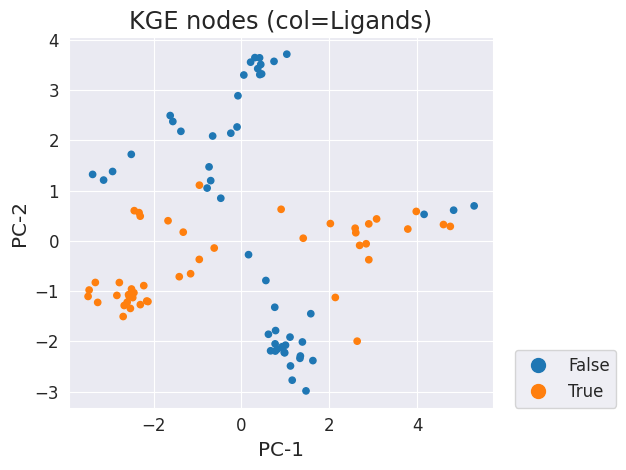

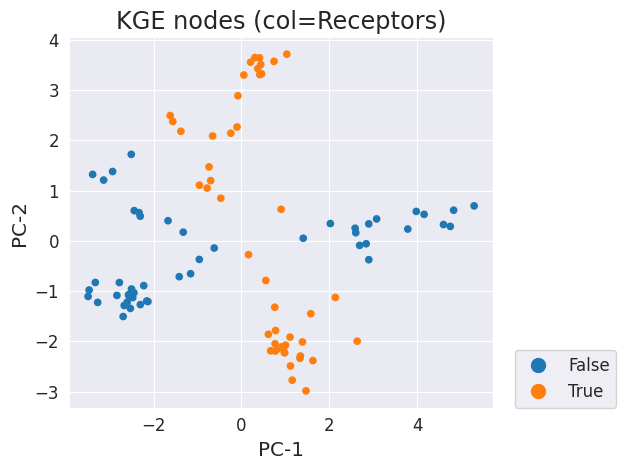

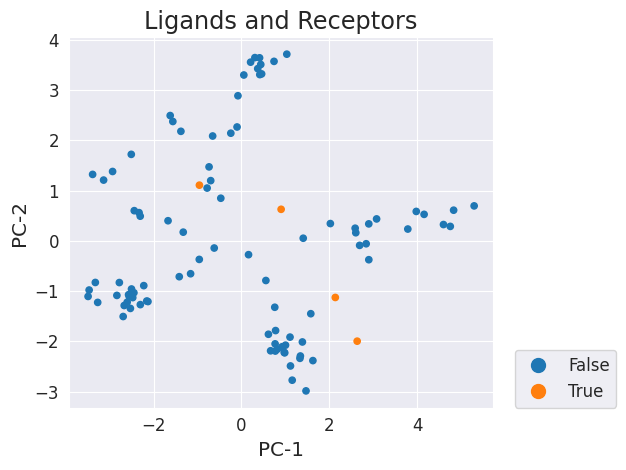

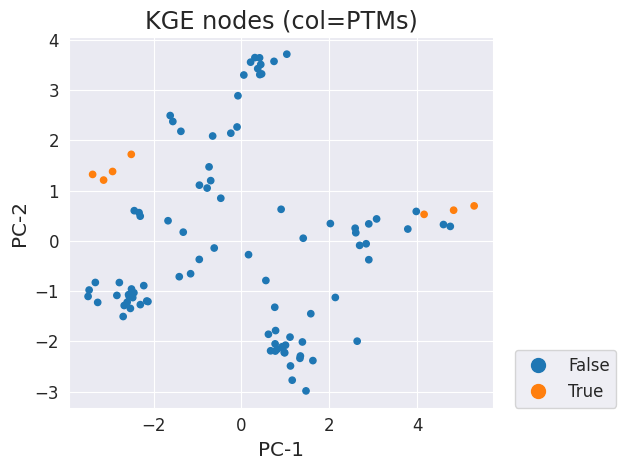

In [69]:
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"]),
    title="KGE nodes (col=Ligands)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["Receptors"]==True, "entity"]),
    title="KGE nodes (col=Receptors)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=l_and_r,
    title="Ligands and Receptors", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["PTMs"]==True, "entity"]),
    title="KGE nodes (col=PTMs)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

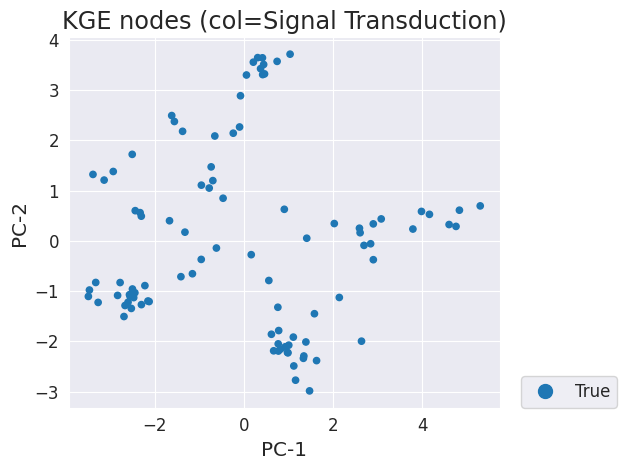

In [70]:
for i in mdEntities["1stPathways"].dropna().unique():
    scprep.plot.scatter2d(dKGEn_pca,
        c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["1stPathways"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

In [71]:
dKGEn_phate = phate.PHATE().fit_transform(dKGEnodes_50)
dKGEn_phate = pd.DataFrame(dKGEn_phate, index=entityIDS.values())

Calculating PHATE...
  Running PHATE on 95 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 20
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.03 seconds.


<AxesSubplot: title={'center': 'KGE nodes (col=Degree)'}, xlabel='PC-1', ylabel='PC-2'>

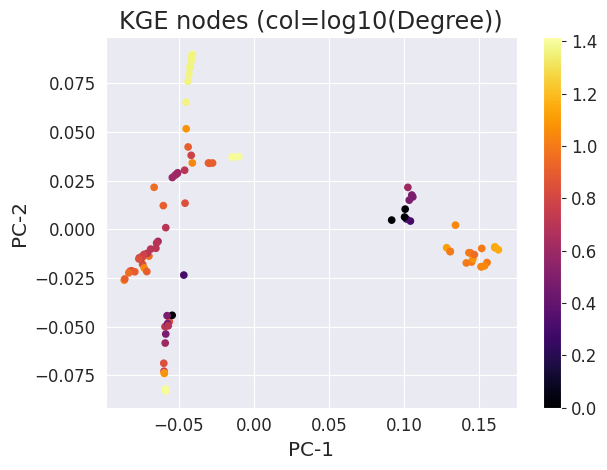

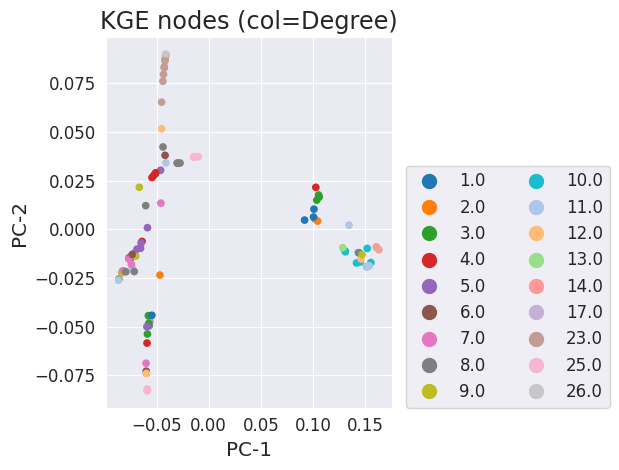

In [72]:
scprep.plot.scatter2d(dKGEn_phate,
    c=logdeg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=log10(Degree))", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_phate,
    c=deg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=Degree)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

<AxesSubplot: title={'center': 'KGE nodes (col=PTMs)'}, xlabel='PC-1', ylabel='PC-2'>

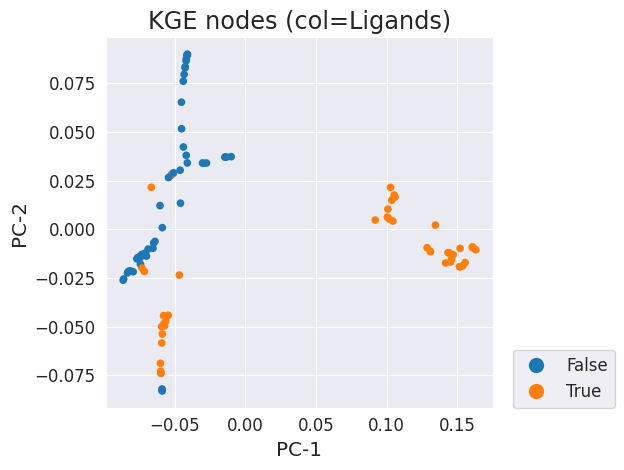

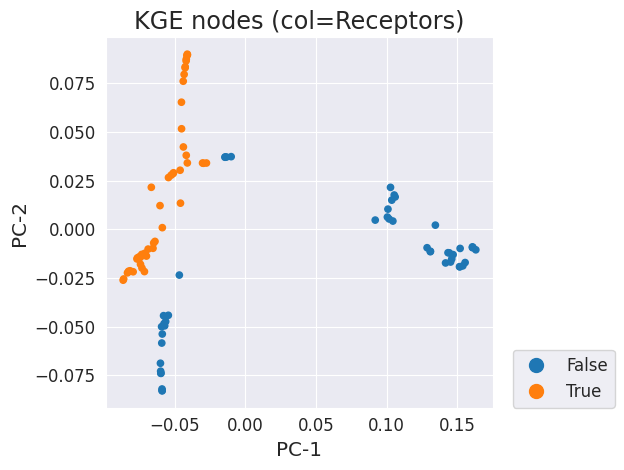

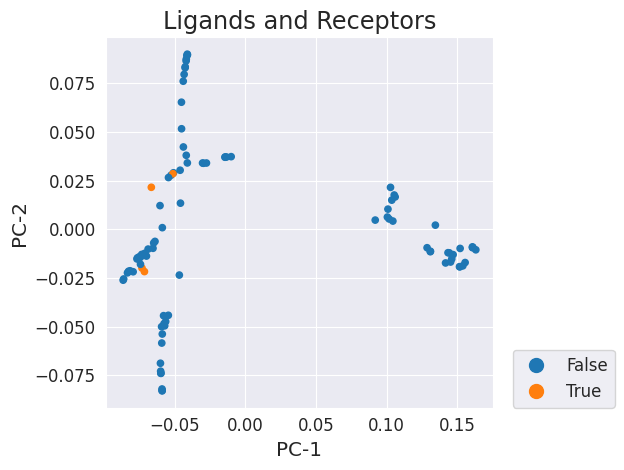

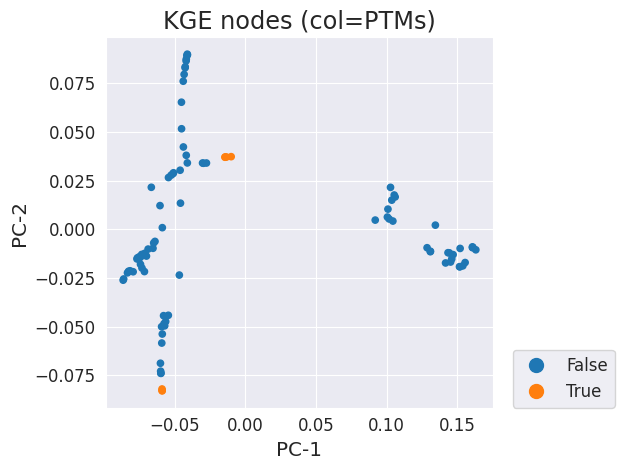

In [73]:
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"]),
    title="KGE nodes (col=Ligands)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["Receptors"]==True, "entity"]),
    title="KGE nodes (col=Receptors)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_phate,
    c=l_and_r,
    title="Ligands and Receptors", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["PTMs"]==True, "entity"]),
    title="KGE nodes (col=PTMs)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

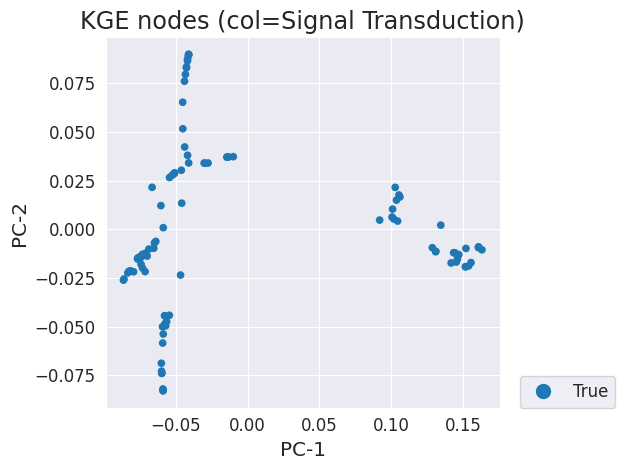

In [74]:
for i in mdEntities["1stPathways"].dropna().unique():
    scprep.plot.scatter2d(dKGEn_phate,
        c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["1stPathways"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

In [75]:
list(mdPath2Path.loc[mdPath2Path[0]=="Signal Transduction",1])

['Signaling by TGFB family members', 'Signaling by WNT']

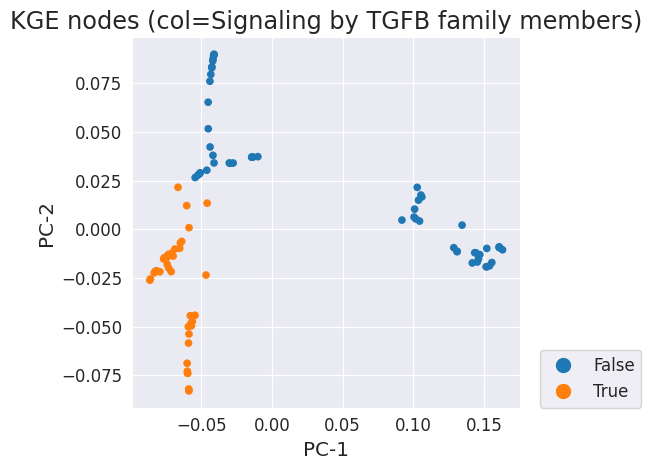

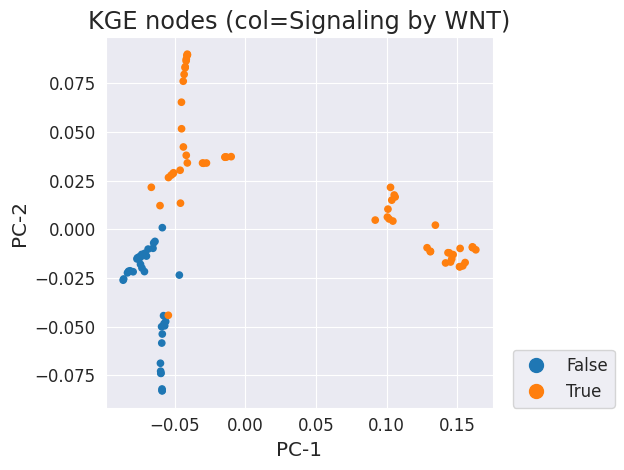

In [76]:
for i in mdPath2Path.loc[mdPath2Path[0]=="Signal Transduction",1]:
    scprep.plot.scatter2d(dKGEn_phate,
        c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["pathway"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

Removing the non pathway annotated LR nodes actually seems to decrease esttrucutrre on phate of KGE

## Edges
Will need to use the top level pathways from REACTOME as way of annotating the edges to see if there's any kind of logical ordering to it

In [77]:
trained_model.relation_representations[0](indices=None).detach().cpu().numpy().shape

(2, 50)

In [78]:
relationIDS.values()

dict_values(['Signaling by TGFB family members', 'Signaling by WNT'])

In [79]:
#Construct edges dataframe
relation_embeddings = trained_model.relation_representations[0](indices=None).detach().cpu().numpy()
dKGEedges_50 = pd.DataFrame(relation_embeddings, index=relationIDS.values())
dKGEedges_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Signaling by TGFB family members,0.219608,0.167253,-0.302043,0.060353,-0.353845,0.173874,0.216953,-0.014374,0.301265,-0.383253,...,-0.325893,-0.333081,-0.29649,-0.075551,0.232467,-0.234785,-0.194080,0.175735,0.17938,-0.392348
Signaling by WNT,0.089090,0.350242,0.194398,-0.128218,0.059751,0.256843,-0.078322,0.136106,0.113265,-0.406129,...,0.029893,-0.036900,-0.35852,-0.266127,0.202215,0.006730,-0.338043,0.208438,0.20536,0.265462


### DR on KGE

In [80]:
from sklearn.decomposition import PCA

dKGEe_pca = PCA(n_components=2).fit_transform(dKGEedges_50)
dKGEe_pca = pd.DataFrame(dKGEe_pca, index=relationIDS.values())

In [81]:
mdPath2Path.set_index([1]).reindex(relationIDS.values())

,0
1,
Signaling by TGFB family members,Signal Transduction
Signaling by WNT,Signal Transduction


<AxesSubplot: title={'center': 'Edges'}, xlabel='PC-1', ylabel='PC-2'>

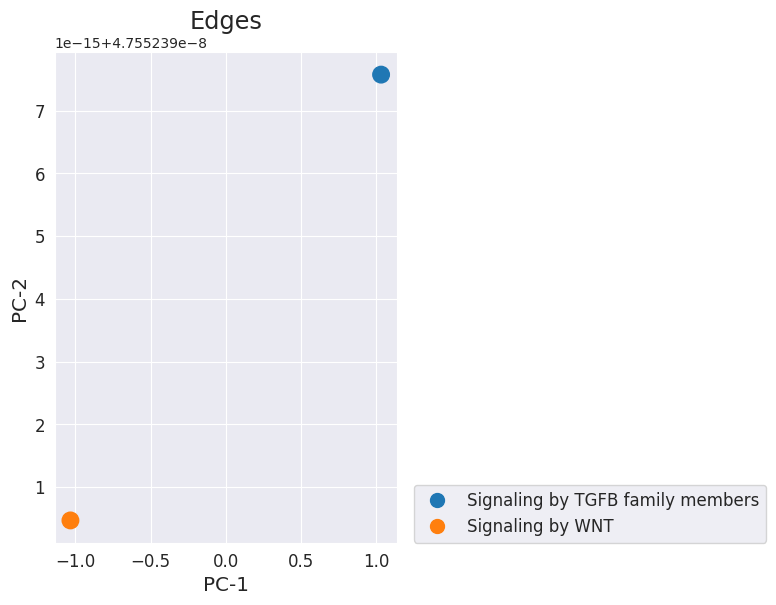

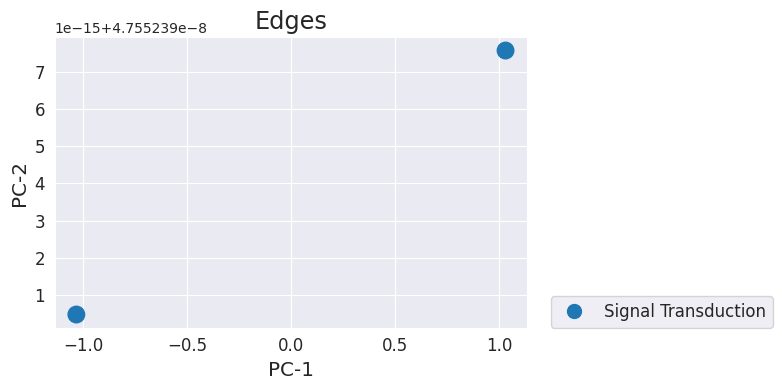

In [82]:
scprep.plot.scatter2d(dKGEe_pca,
    c=dKGEe_pca.index,
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_pca,
    c=mdPath2Path.set_index([1]).reindex(relationIDS.values()),
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)

In [83]:
dKGEe_phate = phate.PHATE().fit_transform(dKGEedges_50)
dKGEe_phate = pd.DataFrame(dKGEe_phate, index=relationIDS.values())

Calculating PHATE...
  Running PHATE on 2 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 35
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.03 seconds.


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/graphtools/graphs.py:104: UserWarning: Cannot set knn (5) to be greater than n_samples - 2 (0). Setting knn=0
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


<AxesSubplot: title={'center': 'Edges'}, xlabel='PHATE-1', ylabel='PHATE-2'>

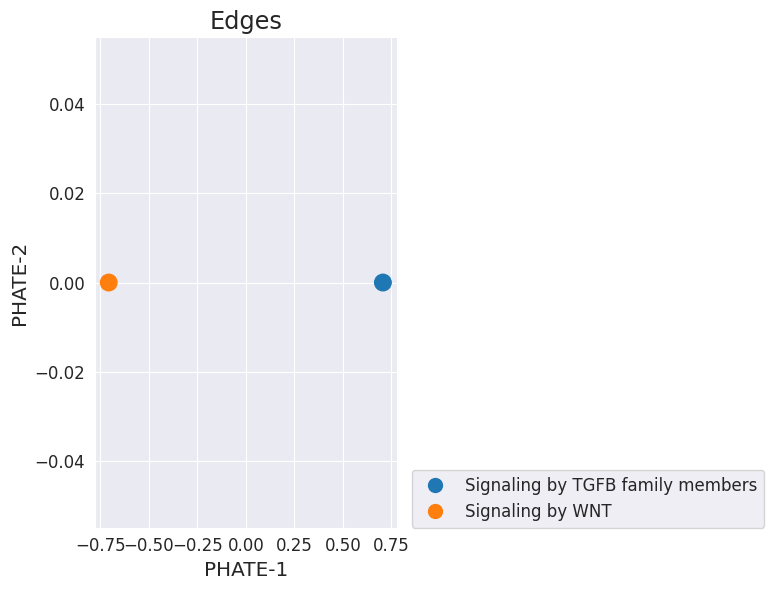

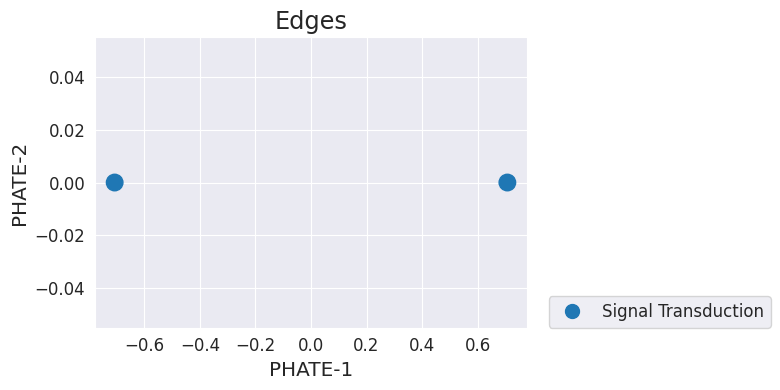

In [84]:
scprep.plot.scatter2d(dKGEe_phate,
    c=dKGEe_phate.index,
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_phate,
    c=mdPath2Path.set_index([1]).reindex(relationIDS.values()),
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)

# PHATE directly of KG
SKip the Embedding step and use PHATE directly on KG. See if, with only one edge type,
we still have the same separation of Ligands/Receptors

Really not relevant since we aren't using edge information if projecting data on wavelet dictionaries on non Multigraphs (be it directed or otherwise) [and we also already know directness is much more important than multiVSsimple].


In [85]:
import graphtools #SOme kind of networkx wrapper/extension/mod from smita's lab

In [86]:
testG = graphtools.Graph(networkx.adj_matrix(G), precomputed='adjacency')

/tmp/ipykernel_20864/4001579142.py:1: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  testG = graphtools.Graph(networkx.adj_matrix(G), precomputed='adjacency')
/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


In [87]:
networkx.info(testG)

/tmp/ipykernel_20864/2698631980.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  networkx.info(testG)


'<graphtools.graphs.TraditionalGraph object at 0x2b0abd47f880>'

In [88]:
data_phate = phate.PHATE(random_state=42).fit_transform(testG)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 95 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 13
  Calculating diffusion potential...
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
  Calculated metric MDS in 0.07 seconds.
Calculated PHATE in 0.09 seconds.


In [89]:
G.nodes()

NodeView(('TGFB1', 'TGFBR1', 'TGFBR2', 'TGFB2', 'TGFB3', 'INHBA', 'ACVR1', 'ACVR2A', 'ACVR1B', 'ACVR2B', 'INHBB', 'AMH', 'AMHR2', 'BMP2', 'BMPR2', 'BMPR1B', 'BMPR1A', 'F11R', 'RSPO1', 'LGR4', 'LGR6', 'LGR5', 'RSPO4', 'RSPO3', 'RSPO2', 'WNT4', 'FZD6', 'WNT5A', 'WNT3A', 'BMP10', 'ACVRL1', 'DKK1', 'LRP6', 'DKK2', 'F7', 'F3', 'GDF2', 'BAMBI', 'SOST', 'LRP5', 'WNT11', 'FZD7', 'WNT1', 'FZD3', 'FZD8', 'RYK', 'WNT3', 'FZD2', 'FZD4', 'WNT7A', 'FZD5', 'WNT7B', 'FZD1', 'ROR2', 'ITGB6', 'ITGAV', 'ITGB8', 'ACVR1C', 'ITGB3', 'ITGB5', 'ITGA8', 'ITGB1', 'LTB', 'WNT2', 'SFRP1', 'RHO', 'WNT10B', 'WNT9B', 'WNT10A', 'WNT8B', 'WNT9A', 'ROR1', 'WNT8A', 'FBN1', 'INHB', 'WNT16', 'WNT2B', 'WNT6', 'WNT5B', 'LTA', 'F2', 'PARD3', 'COL1A2', 'H3F3A', 'ITPR3', 'ITPR1', 'AR', 'CALM1', 'GNAT2', 'p-\\S*T308\\S*-AKT1', 'p-\\S*S473\\S*-AKT1', 'p-\\S+-SMAD(1|5|9)', 'GSK3B', 'p-\\S+-MAPK(3|1)\\s+', 'p-\\S+-SMAD(2|3)'))

In [90]:
pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"])

array([ True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
        True, False, False, False,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False])

<AxesSubplot: title={'center': '(col=Ligands)'}, xlabel='PHATE-1', ylabel='PHATE-2'>

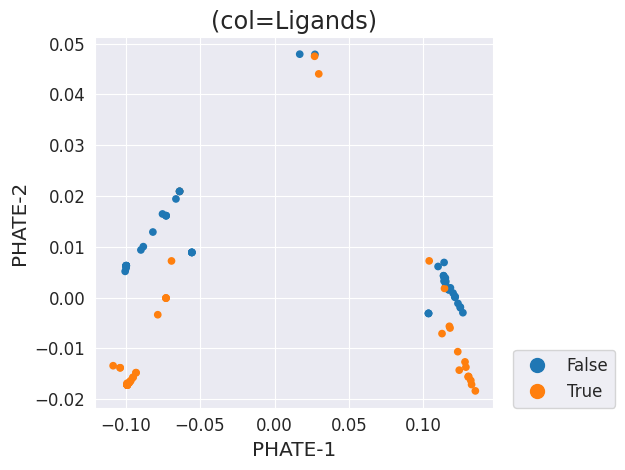

In [91]:
scprep.plot.scatter2d(data_phate,
    c=pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"]),
    title="(col=Ligands)", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

<AxesSubplot: title={'center': '(col=Receptors)'}, xlabel='PHATE-1', ylabel='PHATE-2'>

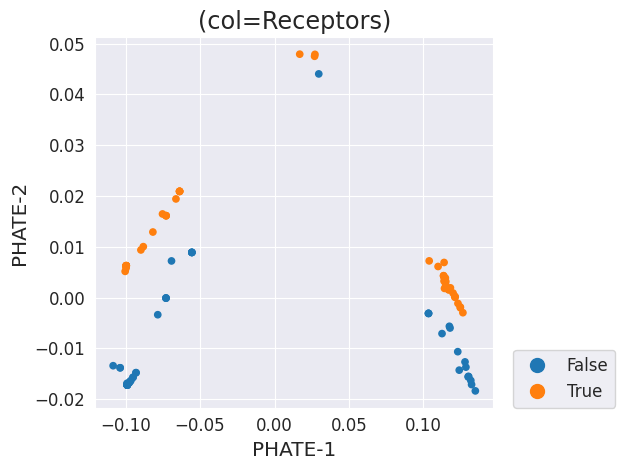

In [92]:
scprep.plot.scatter2d(data_phate,
    c=pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["Receptors"]==True, "entity"]),
    title="(col=Receptors)", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

<AxesSubplot: title={'center': '(col=PTMs)'}, xlabel='PHATE-1', ylabel='PHATE-2'>

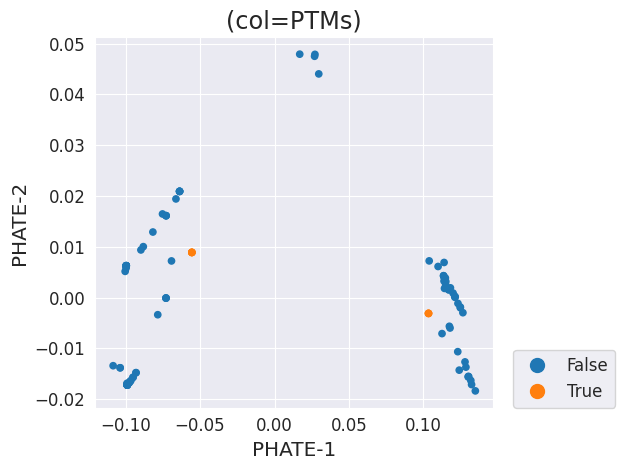

In [95]:
scprep.plot.scatter2d(data_phate,
    c=pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["PTMs"]==True, "entity"]),
    title="(col=PTMs)", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

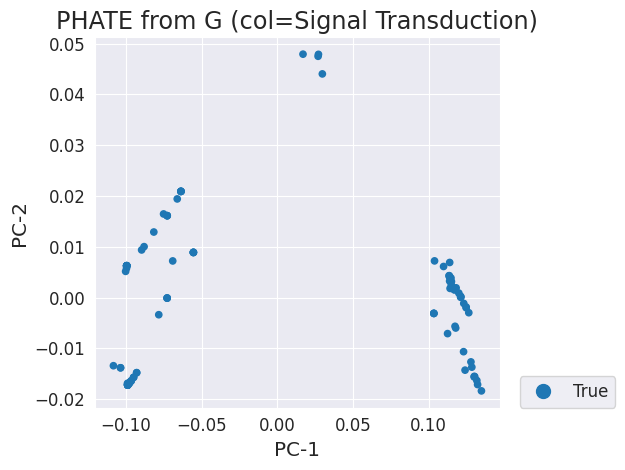

In [93]:
for i in mdEntities["1stPathways"].dropna().unique():
    scprep.plot.scatter2d(data_phate,
        c=pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["1stPathways"]==i, "entity"]),
        title=f"PHATE from G (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

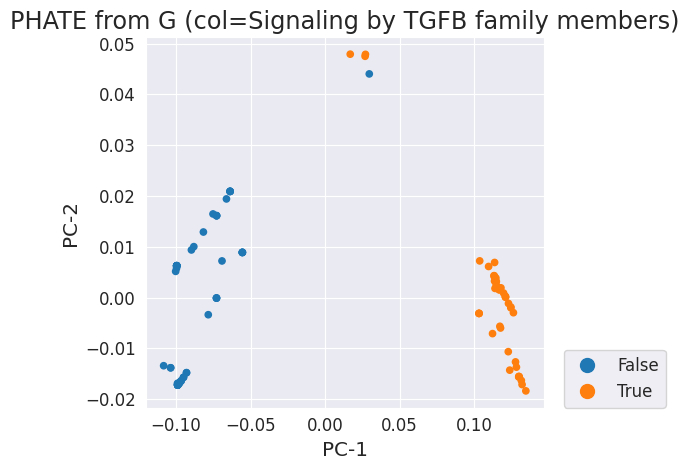

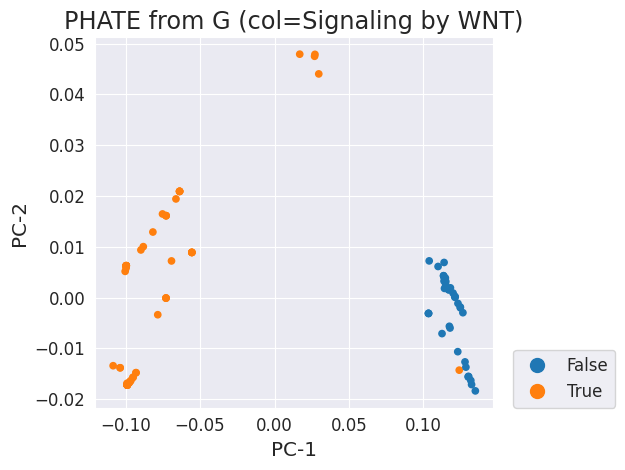

In [94]:
for i in mdPath2Path.loc[mdPath2Path[0]=="Signal Transduction",1]:
    scprep.plot.scatter2d(data_phate,
        c=pd.Series(G.nodes()).index.isin(mdEntities.loc[mdEntities["pathway"]==i, "entity"]),
        title=f"PHATE from G (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)